In [1]:
import numpy as np
np.random.seed(2023)
import random
random.seed(2023)
print('[INFO] Using numpy {0}'.format(np.__version__))

import os
import sys
import time
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import initializers, regularizers, optimizers, losses
K.set_epsilon(1e-08)
print('[INFO] Using keras {0}'.format(keras.__version__))

import tensorflow as tf
print('[INFO] Using tensorflow {0}'.format(tf.__version__))

import sklearn
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
print('[INFO] Using sklearn {0}'.format(sklearn.__version__))

#import pandas as pd
#import statsmodels

import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline


# ______________________________________________________________________________
# Globals
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

infile = '../test2/histos_tba.12.npz'


[INFO] Using numpy 1.12.1


Using TensorFlow backend.


[INFO] Using keras 2.0.5
[INFO] Using tensorflow 1.1.0
[INFO] Using sklearn 0.18.1


In [2]:
#### Load data ####

try:
    loaded = np.load(infile)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
except:
    print('[ERROR] Failed to load data from file: {0}'.format(infile))

print('[INFO] Loaded the variables with shape {0}'.format(the_variables.shape))
print('[INFO] Loaded the parameters with shape {0}'.format(the_parameters.shape))

[INFO] Loaded the variables with shape (3646057, 76)
[INFO] Loaded the parameters with shape (3646057, 3)


In [3]:
class Encoder(object):

  def __init__(self, x, y, adjust_scale=0):
    if x is not None and y is not None:
      assert(x.shape[1] == (nlayers * 6) + 4)
      assert(y.shape[1] == 3)
      assert(x.shape[0] == y.shape[0])

      self.nentries = x.shape[0]
      self.x_orig  = x
      self.y_orig  = y
      self.x_copy  = x.copy()
      self.y_copy  = y.copy()

      # Get views
      self.x_phi   = self.x_copy[:, nlayers*0:nlayers*1]
      self.x_theta = self.x_copy[:, nlayers*1:nlayers*2]
      self.x_bend  = self.x_copy[:, nlayers*2:nlayers*3]
      self.x_ring  = self.x_copy[:, nlayers*3:nlayers*4]
      self.x_fr    = self.x_copy[:, nlayers*4:nlayers*5]
      self.x_mask  = self.x_copy[:, nlayers*5:nlayers*6].astype(np.bool)  # this makes a copy
      self.x_road  = self.x_copy[:, nlayers*6:nlayers*7]  # ipt, ieta, iphi, iphi_corr
      self.y_pt    = self.y_copy[:, 0]  # q/pT
      self.y_phi   = self.y_copy[:, 1]
      self.y_eta   = self.y_copy[:, 2]
      
      # Make event weight
      #self.w       = np.ones(self.y_pt.shape, dtype=np.float32)
      self.w       = np.abs(self.y_pt)/0.2 + 1.0
      
      # Straightness & zone
      self.x_straightness = self.x_road[:, 0][:, np.newaxis].astype(np.int32)
      self.x_zone         = self.x_road[:, 1][:, np.newaxis].astype(np.int32)
      
      # Subtract median phi from hit phis
      #self.x_phi_median    = self.x_road[:, 2] * 32 - 16  # multiply by 'quadstrip' unit (4 * 8)
      self.x_phi_median    = self.x_road[:, 2] * 16 - 8  # multiply by 'doublestrip' unit (2 * 8)
      self.x_phi_median    = self.x_phi_median[:, np.newaxis]
      self.x_phi          -= self.x_phi_median
      
      # Subtract median theta from hit thetas
      self.x_theta_median  = np.nanmedian(self.x_theta[:,:5], axis=1)  # CSC only
      self.x_theta_median[np.isnan(self.x_theta_median)] = np.nanmedian(self.x_theta[np.isnan(self.x_theta_median)], axis=1)  # use all
      self.x_theta_median  = self.x_theta_median[:, np.newaxis]
      self.x_theta        -= self.x_theta_median
      
      # Standard scales
      if adjust_scale == 0:  # do not adjust
        pass
      elif adjust_scale == 1:  # use mean and std
        self.x_mean  = np.nanmean(self.x_copy, axis=0)
        self.x_std   = np.nanstd(self.x_copy, axis=0)
        self.x_std   = self._handle_zero_in_scale(self.x_std)
        self.x_copy -= self.x_mean
        self.x_copy /= self.x_std
      elif adjust_scale == 2:  # adjust by hand
        self.x_phi   *= 0.000991  # GE1/1 dphi linear correlation with q/pT
        self.x_theta *= (1/12.)   # 12 integer theta units
        self.x_bend  *= 0.188082  # ME1/2 bend linear correlation with q/pT
        x_ring_tmp    = self.x_ring.astype(np.int32)
        x_ring_tmp    = (x_ring_tmp == 1) | (x_ring_tmp == 4)
        np.place(self.x_ring, x_ring_tmp, 0)  # ring 1,4 -> 0
        np.place(self.x_ring, ~x_ring_tmp, 1) # ring 2,3 -> 1
        #self.x_fr     = self.x_fr
      
      # Remove outlier hits by checking hit thetas
      if adjust_scale == 0:  # do not adjust
        x_theta_tmp = np.abs(self.x_theta) > 10000.0
      elif adjust_scale == 1:  # use mean and std
        x_theta_tmp = np.abs(self.x_theta) > 1.0
      elif adjust_scale == 2:  # adjust by hand
        theta_cuts    = np.array((6., 6., 6., 6., 6., 12., 12., 12., 12., 9., 9., 9.), dtype=np.float32)
        theta_cuts   *= (1/12.)   # 12 integer theta units
        assert(len(theta_cuts) == nlayers)
        x_theta_tmp = np.abs(self.x_theta) > theta_cuts
      self.x_phi  [x_theta_tmp] = np.nan
      self.x_theta[x_theta_tmp] = np.nan
      self.x_bend [x_theta_tmp] = np.nan
      self.x_ring [x_theta_tmp] = np.nan
      self.x_fr   [x_theta_tmp] = np.nan
      self.x_mask [x_theta_tmp] = 1.0
      
      # Add variables: straightness, zone, theta_median and mode variables
      self.x_straightness /= np.max(self.x_straightness)
      self.x_zone         /= np.max(self.x_zone)
      self.x_theta_median -= 3.  # scaled to [0,1]
      self.x_theta_median /= 83.
      hits_to_station = np.array((5,1,2,3,4,1,2,3,4,5,2,5), dtype=np.int32)  # '5' denotes ME1/1
      assert(len(hits_to_station) == nlayers)
      self.x_mode_vars = np.zeros((self.nentries, 5), dtype=np.bool)
      self.x_mode_vars[:,0] = np.any(self.x_mask[:,hits_to_station == 5] == 0, axis=1)
      self.x_mode_vars[:,1] = np.any(self.x_mask[:,hits_to_station == 1] == 0, axis=1)
      self.x_mode_vars[:,2] = np.any(self.x_mask[:,hits_to_station == 2] == 0, axis=1)
      self.x_mode_vars[:,3] = np.any(self.x_mask[:,hits_to_station == 3] == 0, axis=1)
      self.x_mode_vars[:,4] = np.any(self.x_mask[:,hits_to_station == 4] == 0, axis=1)
      
      # Remove NaN
      #np.nan_to_num(self.x_copy, copy=False)
      self.x_copy[np.isnan(self.x_copy)] = 0.0

  # Copied from scikit-learn
  def _handle_zero_in_scale(self, scale):
    scale[scale == 0.0] = 1.0
    return scale

  def get_x(self):
    #x_new = self.x_phi
    x_new = np.hstack((self.x_phi, self.x_theta, self.x_bend, self.x_ring, self.x_fr, self.x_mask, self.x_straightness, self.x_zone, self.x_theta_median, self.x_mode_vars))
    return x_new

  def get_x_mask(self):
    x_mask = self.x_mask.copy()
    return x_mask

  def get_x_zone(self):
    x_zone = self.x_zone.copy()
    return x_zone

  def get_y(self):
    y_new = self.y_pt.copy()
    return y_new

  def get_w(self):
    w_new = self.w.copy()
    return w_new

  def save_encoder(self, filepath):
    np.savez_compressed(filepath, x_mean=self.x_mean, x_std=self.x_std)

  def load_endcoder(self, filepath):
    loaded = np.load(filepath)
    self.x_mean = loaded['x_mean']
    self.x_std = loaded['x_std']

In [4]:
#### Prepare data ####

# Preprocess data
encoder = Encoder(the_variables, the_parameters, adjust_scale=2)
x, y, w, x_mask = encoder.get_x(), encoder.get_y(), encoder.get_w(), encoder.get_x_mask()
#encoder.save_encoder('encoder.npz')
#print('[INFO] Encoder is saved as encoder.npz')

# Split dataset in training and testing
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = train_test_split(x, y, w, x_mask, test_size=0.4)

nvariables = x_train.shape[1]
nparameters = 1
print('[INFO] Using {0} variables and {1} parameters'.format(nvariables, nparameters))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.12.1-mlhled2/lib/python2.7/site-packages/numpy-1.12.1-py2.7-linux-x86_64.egg/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda6/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


[INFO] Using 80 variables and 1 parameters


In [5]:
print x, y, w
print np.mean(x, axis=0)
print np.std(x, axis=0)
print np.isfinite(x).all()

[[ 0.22594799  0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.026757   -0.011892   ...,  1.          1.          1.        ]
 [ 0.          0.007928    0.003964   ...,  1.          1.          1.        ]
 ..., 
 [ 0.31216499  0.          0.         ...,  1.          1.          1.        ]
 [ 0.095136    0.         -0.031712   ...,  1.          1.          1.        ]
 [ 0.15955099  0.         -0.055496   ...,  1.          1.          1.        ]] [ 0.45731288  0.14871465  0.01238597 ...,  0.37654495  0.13762507
  0.43144876] [ 3.28656435  1.74357319  1.06192982 ...,  2.88272476  1.68812537
  3.15724373]
[ -1.13775592e-03  -1.21299871e-03  -2.28875016e-03  -2.46193978e-03
  -2.64842127e-03  -1.21418267e-03  -8.58956872e-04  -2.24852369e-03
  -2.14635281e-03  -8.11381462e-04  -9.54983974e-04   0.00000000e+00
   7.08065494e-02   2.37236080e-02   4.38936511e-03  -2.49883534e-02
  -2.73195018e-02   1.42394468e-02   1.46509644e-02  -2.97815567e-02
  -1.15

In [6]:
#### Create a model ####

# See https://keras.io/models/about-keras-models/
#     https://keras.io/layers/about-keras-layers/
# for all kinds of things you can do with Keras

# Define model
#model = Sequential()
#model.add(Dense(8, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_normal'))
#model.add(Dense(4, activation='tanh', kernel_initializer='glorot_normal'))
#model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

#model = Sequential()
#model.add(Dense(64, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
#model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
#model.add(Dense(8, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l1(0.0000)))
#model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

model = Sequential()
model.add(Dense(64, input_dim=nvariables, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
#model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
#model.add(Dropout(0.2))
model.add(Dense(16, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0000)))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='linear', kernel_initializer='glorot_uniform'))

# Set loss and optimizer
def huber_loss(y_true, y_pred, delta=1.345):
  x = K.abs(y_true - y_pred)
  squared_loss = 0.5*K.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  #xx = K.switch(x < delta, squared_loss, absolute_loss)
  xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
  return K.mean(xx, axis=-1)

# from https://arogozhnikov.github.io/hep_ml/_modules/hep_ml/nnet.html#smooth_huber_loss
def smooth_huber_loss(y_true, y_pred):
  x = K.abs(y_true - y_pred)
  return K.mean(x + K.log(1 + K.exp(-2 * x)), axis=-1)

def pseudo_huber_loss(y_true, y_pred, delta=1.0):
  delta2 = delta * delta
  x = delta2 * (K.sqrt(1 + K.square(y_true - y_pred)/delta2) - 1)
  return K.mean(x, axis=-1)

# Learning rate decay by epoch number
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
  if (epoch % 20) == 0:
    lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, lr*0.95)
    print("lr changed to {}".format(lr*0.95))
  return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(lr_schedule)


adam = optimizers.Adam(lr=0.001)
#adam = optimizers.Adam(lr=0.005)
#adam = optimizers.Adam(lr=0.001, amsgrad=True)
#adam = optimizers.Adam(lr=0.0001, decay=0.00001,)
#rmsprop = optimizers.RMSprop(lr=0.0001, decay=0.00001,)

# Compile
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc', 'mse', 'mae'])
#model.compile(loss='mean_squared_error', optimizer=adam, metrics=['acc', 'mse', 'mae'])
#model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['acc', 'mse', 'mae'])
model.compile(loss=huber_loss, optimizer=adam, metrics=['acc', 'mse', 'mae'])
#model.compile(loss=huber_loss, optimizer=rmsprop, metrics=['acc', 'mse', 'mae'])
#model.compile(loss='logcosh', optimizer='adam', metrics=['acc', 'mse', 'mae'])

In [7]:
#### Training ####

#history = model.fit(x_train, y_train, epochs=400, validation_split=0.2, batch_size=1000, verbose=1)

# The webpage can become very unresponsive when you train with a large dataset with the above comment.
# So I do the following instead.
# See issue https://github.com/jupyter/notebook/issues/1474

start_time = time.time()
old_stdout = sys.stdout
sys.stdout = open('keras_output.txt', 'w')
#history = model.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=256, verbose=1)
#history = model.fit(x_train, y_train, epochs=40, validation_split=0.1, batch_size=256, callbacks=[lr_decay], verbose=1)
history = model.fit(x_train, y_train, epochs=400, validation_split=0.1, batch_size=256, callbacks=[lr_decay], verbose=0)
#history = model.fit(x_train, y_train, sample_weight=w_train, epochs=40, validation_split=0.1, batch_size=256, verbose=1)
#history = model.fit(x_train, y_train, sample_weight=w_train, epochs=200, validation_split=0.1, batch_size=256, verbose=0)
sys.stdout.close()
sys.stdout = old_stdout
print('[INFO] Time elapsed: {0} sec'.format(time.time() - start_time))

# Store model to file
model.summary()
model.save('model.h5')
model.save_weights('model_weights.h5')

# Store model to json
import json
with open('model.json', 'w') as outfile:
  json.dump(model.to_json(), outfile)
  
print('[INFO] Model is saved as model.h5, model.json and model_weights.h5')

[INFO] Time elapsed: 7950.38951111 sec
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 7,809
Trainable params: 7,809
Non-trainable params: 0
_________________________________________________________________
[INFO] Model is saved as model.h5, model.json and model_weights.h5


1449000/1458423 [============================>.] - ETA: 0s[INFO] loss and metrics: [0.00059444685902505117, 0.0, 0.0011888937180501023, 0.023013171547718664]


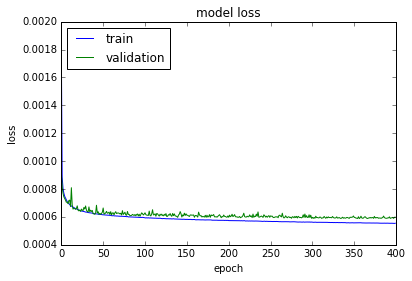

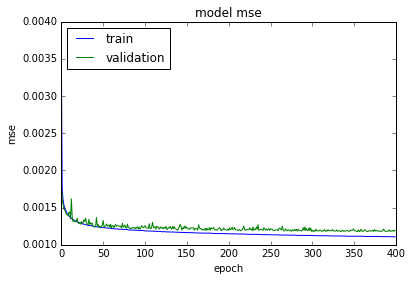

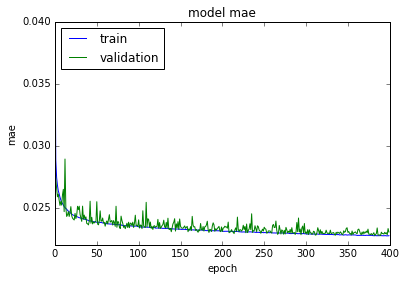

In [8]:
#### Evaluation using Keras internal tool ####

loss_and_metrics = model.evaluate(x_test, y_test, batch_size=1000)
#loss_and_metrics = model.evaluate(x_test, y_test, sample_weight=w_test, batch_size=1000)
print('[INFO] loss and metrics: {0}'.format(loss_and_metrics))

## Accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
#plt.show()

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Squared Error
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Mean Absolute Error
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Welcome to JupyROOT 6.10/05
243070.0 -0.00175357298803 0.0329832750227


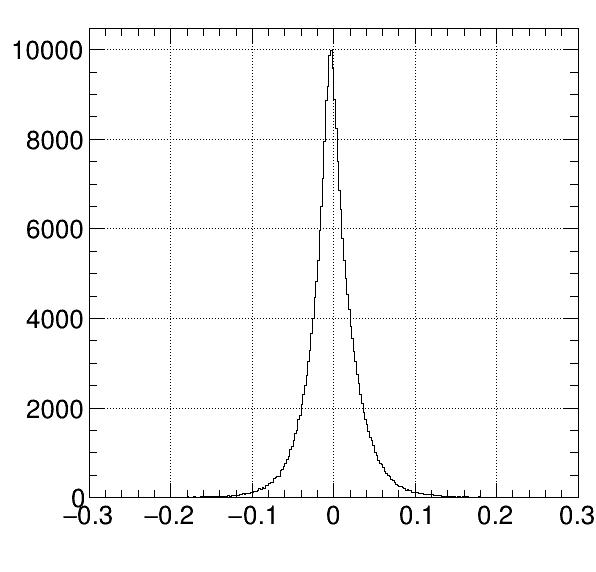

In [9]:
#### Application ####

from keras.models import load_model
import ROOT

# Load model
loaded_model = load_model('model.h5', custom_objects={'huber_loss': huber_loss})
loaded_model.load_weights('model_weights.h5')

ROOT.gROOT.LoadMacro("tdrstyle.C")
ROOT.gROOT.ProcessLine("setTDRStyle();")
ROOT.gStyle.SetPalette(57)  # kBird
ROOT.gStyle.SetPadGridX(True)
ROOT.gStyle.SetPadGridY(True)

h1 = ROOT.TH1F("h1", "h1", 300, -0.3, 0.3)
h2a = ROOT.TH2F("h2a", "h2a", 100, -0.5, 0.5, 300, -0.3, 0.3)
h2b = ROOT.TH2F("h2b", "h2b", 100, -0.5, 0.5, 300, -0.5, 0.5)
h2c = ROOT.TH2F("h2c", "h2c", 100, -0.5, 0.5, 400, -2, 2)
h2d = ROOT.TH2F("h2d", "h2d", 100, -0.5, 0.5, 400, -2, 2)

nentries_test = x_test.shape[0]/6
#nentries_test = 100000

y_test_meas = loaded_model.predict(x_test[:nentries_test, :])


# Loop over events
for i in xrange(nentries_test):
  y_true = y_test[i]
  y_meas = y_test_meas[i]
  h1.Fill(y_meas - y_true)
  h2a.Fill(y_true, y_meas - y_true) 
  h2b.Fill(y_true, y_meas)
  h2c.Fill(y_true, (y_meas - y_true)/abs(y_true))
  h2d.Fill(abs(y_true), (abs(y_meas) - abs(y_true))/abs(y_true)) 

# Draw
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

print h1.GetEntries(), h1.GetMean(), h1.GetRMS()

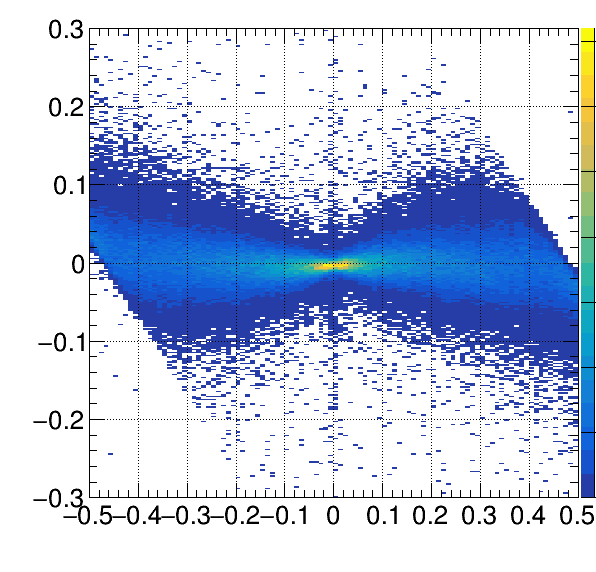

In [10]:
c = ROOT.TCanvas()
h2a.Draw("COLZ")
c.Draw()

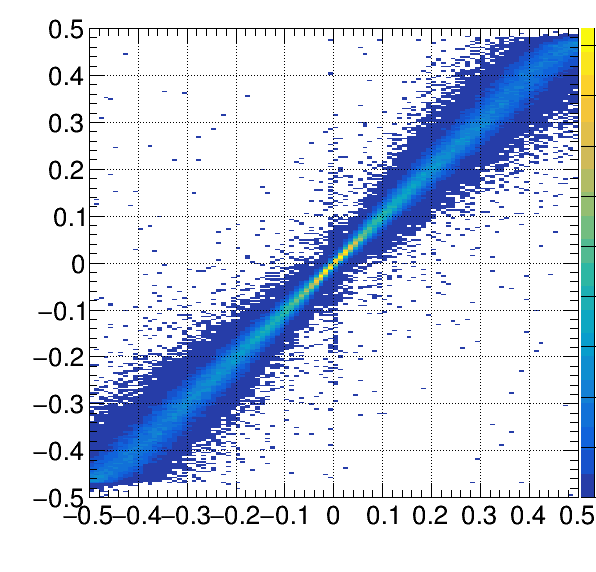

In [11]:
c = ROOT.TCanvas()
h2b.Draw("COLZ")
c.Draw()

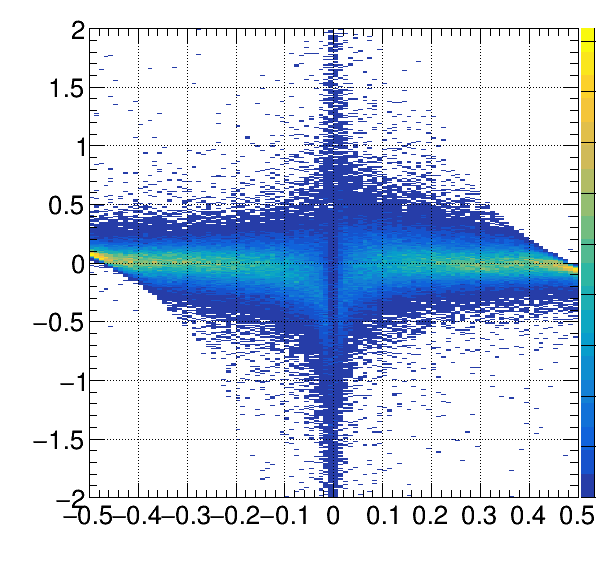

In [12]:
c = ROOT.TCanvas()
h2c.Draw("COLZ")
c.Draw()

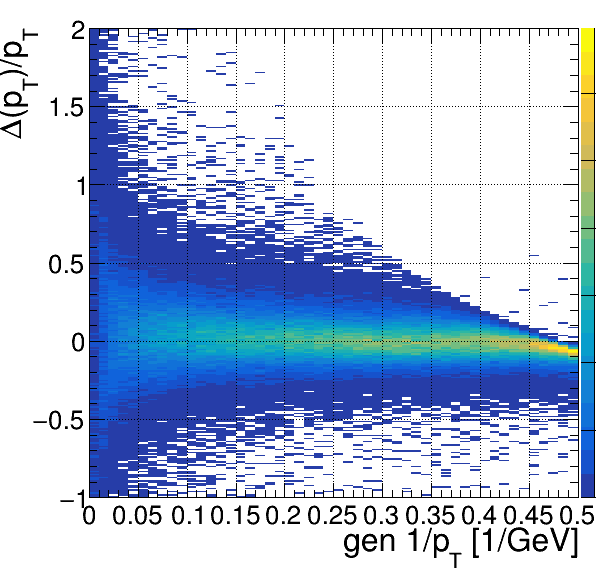

In [13]:
c = ROOT.TCanvas()
h2d.SetStats(0)
h2d.SetTitle("")
h2d.GetXaxis().SetTitle("gen 1/p_{T} [1/GeV]")
h2d.GetYaxis().SetTitle("#Delta(p_{T})/p_{T}")
h2d.GetXaxis().SetRangeUser(0, 0.5)
h2d.GetYaxis().SetRangeUser(-1, 2)
h2d.Draw("COLZ")
c.Draw()

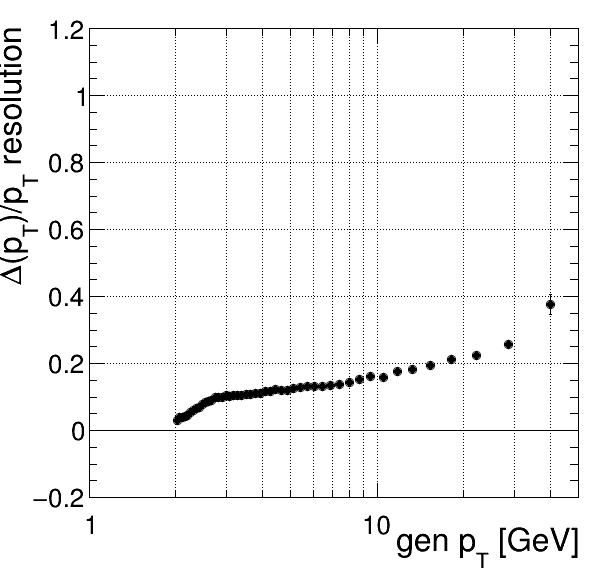

In [14]:
c = ROOT.TCanvas()

hname = "h2d"
h = h2d.Clone("h2d_clone")
h.Draw("COLZ")
#gPad.Print(hname+".png")
#h.RebinX(2)

h_pfx = h.ProfileX(hname+"_pfx", 1, -1, "s")
h_pfx.SetMaximum(1.2)
h_pfx.SetMinimum(-0.2)
h_pfx.Draw()
#h_pfx.Fit("pol1", "", "", 0.025, 0.2499)
#gPad.Print(h_pfx.GetName()+".png")
#

if True:
  # Apply gaussian fits
  gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr1_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2_aspt = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  for i in xrange(h.GetNbinsX()):
    h_py = h.ProjectionY("_py", i+1, i+1)
    if h_py.Integral() < 15:  continue
    #r = h_py.Fit("gaus", "SNQ")
    r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*8, h_py.GetMean() + 0.04*8)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
    gr1.SetPointError(i, 0, 0, sigma, sigma)
    gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    gr1_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), mean)
    gr1_aspt.SetPointError(i, 0, 0, sigma, sigma)
    gr2_aspt.SetPoint(i, 1.0/h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2_aspt.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
  #
  hname1 = hname
  h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  h_pfx.Draw()
  gr1.Draw("p")
  #gr1.Fit("pol1", "", "", 0.025, 0.2499)
  #gPad.Print(h_pfx.GetName()+".png")
  #
  hname2 = hname
  h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetMaximum(1)
  h_pfx.SetMinimum(0)
  h_pfx.Draw()
  gr2.Draw("p")
  #gr2.Fit("pol1", "", "", 0.025, 0.2499)
  #gPad.Print(h_pfx.GetName()+".png")
  #
  hname1 = hname
  h_pfx = h.ProfileX(hname1+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetBins(50, 0, 50)
  h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
  h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} bias")
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  h_pfx.Draw()
  gr1_aspt.Draw("p")
  #gr1_aspt.Fit("pol1", "", "", 0.025, 0.2499)
  #ROOT.gPad.SetLogx(1)
  #ROOT.gPad.Print(h_pfx.GetName()+".png")
  #ROOT.gPad.SetLogx(0)
  #
  hname2 = hname
  h_pfx = h.ProfileX(hname2+"_pfx", 1, -1, "s")
  h_pfx.Reset()
  h_pfx.SetStats(0)
  h_pfx.SetBins(50, 0, 50)
  h_pfx.GetXaxis().SetTitle("gen p_{T} [GeV]")
  h_pfx.GetYaxis().SetTitle("#Delta(p_{T})/p_{T} resolution")
  h_pfx.SetMaximum(1.2)
  h_pfx.SetMinimum(-0.2)
  #h_pfx.SetMaximum(0.1)
  #h_pfx.SetMinimum(-0.01)
  h_pfx.Draw()
  gr2_aspt.Draw("p")
  #gr2_aspt.Fit("pol1", "", "", 0.025, 0.2499)
  ROOT.gPad.SetLogx(1)
  #ROOT.gPad.Print(h_pfx.GetName()+".png")
  #ROOT.gPad.SetLogx(0)
    
c.Draw()

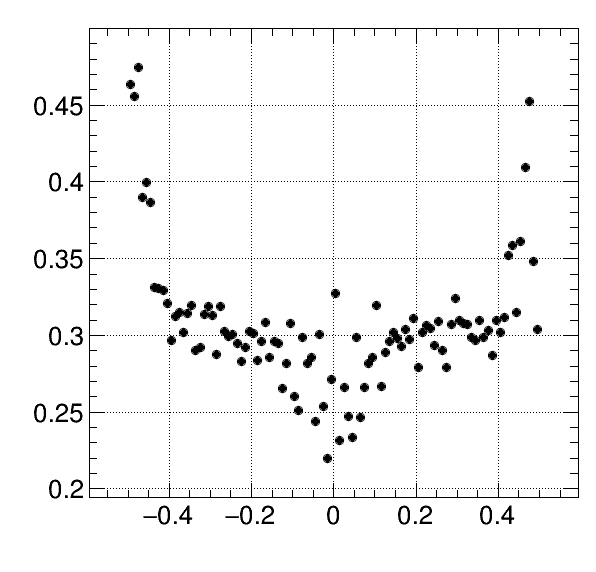

In [15]:
c = ROOT.TCanvas()

hname = "h2b"
h = h2b.Clone("h2b_clone")

if True:
  gr1 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr2 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  gr3 = ROOT.TGraphAsymmErrors(h.GetNbinsX())
  for i in xrange(h.GetNbinsX()):
    h_py = h.ProjectionY("_py", i+1, i+1)
    if h_py.Integral() < 15:  continue
    #r = h_py.Fit("gaus", "SNQ")
    r = h_py.Fit("gaus", "SNQ", "", h_py.GetMean() - 0.04*5, h_py.GetMean() + 0.04*5)
    mean, sigma, meanErr, sigmaErr = r.Parameter(1), r.Parameter(2), r.ParError(1), r.ParError(2)
    #mean, sigma, meanErr, sigmaErr = h_py.GetMean(), h_py.GetRMS(), 0, 0  #FIXME
    gr1.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), mean)
    gr1.SetPointError(i, 0, 0, sigma, sigma)
    gr2.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), sigma)
    gr2.SetPointError(i, 0, 0, sigmaErr, sigmaErr)
    #print h_py.Integral(), h_py.Integral(h_py.FindBin(mean-sigma), h_py.FindBin(mean+sigma))
    loss = 1.0 - h_py.Integral(h_py.FindBin(mean-sigma), h_py.FindBin(mean+sigma)) / h_py.Integral()
    gr3.SetPoint(i, h.GetXaxis().GetBinCenter(i+1), loss)
    gr3.SetPointError(i, 0, 0, 0, 0)
  #
  #gr1.Draw("ap")
  #gr2.Draw("ap")
  gr3.Draw("ap")

c.Draw()

In [16]:
########################## PLEASE IGNORE

In [17]:
if False:
  print x_train.shape, y_train.shape, x_mask_train.shape

  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    mask = x_mask_train[...,(i%nlayers)]
    mask = mask.astype(np.bool)
    if i >= (nlayers*5):
      mask *= False

    #fig, ax = plt.subplots(tight_layout=True)
    xmin, xmax = -3, 3
    ymin, ymax = -0.6, 0.6
    #if (nlayers) <= i < (nlayers*2):
    #  xmin, xmax = -1, 1
    #elif i == 75:
    #  xmin, xmax = -0.5, 1.5
    #elif 76 <= i < 81:
    #  xmin, xmax = -0.5, 1.5
    
    hist = axs[(i/4, i%4)].hist2d(x_train[...,i][~mask], y_train[~mask], bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_train[...,i][~mask].size > 0:
      print i, np.std(x_train[...,i][~mask]), np.percentile(x_train[...,i][~mask], [2,98])

In [18]:
if False:
  df_x = pd.DataFrame(x_train)
  df_y = pd.DataFrame(y_train)
  df = pd.concat([df_x, df_y], axis = 1)
  print df_x.shape, df_y.shape, df.shape
  #print df
  
  df_corr = df.corr()
  plt.figure(figsize=(10,10))
  plt.imshow(df_corr)

In [19]:
if False:
  x_copy  = the_variables.copy()
  y_copy  = the_parameters.copy()
  x_phi   = x_copy[:, nlayers*0:nlayers*1]
  x_theta = x_copy[:, nlayers*1:nlayers*2]
  x_bend  = x_copy[:, nlayers*2:nlayers*3]
  x_mask  = x_copy[:, nlayers*3:nlayers*4]
  x_road  = x_copy[:, nlayers*4:nlayers*5]

  #x_phi_median    = x_road[:, 2] * 32 + 16  # multiply by 'quadstrip' unit (4 * 8)
  x_phi_median    = x_road[:, 2] * 16 + 8  # multiply by 'doublestrip' unit (2 * 8)
  x_phi_median    = x_phi_median[:, np.newaxis]
  x_phi          -= x_phi_median

  x_theta_median  = np.nanmedian(x_theta, axis=1)
  x_theta_median  = x_theta_median[:, np.newaxis]
  x_theta        -= x_theta_median

  x_copy -= encoder.x_mean
  x_copy /= encoder.x_std

  df_x = pd.DataFrame(x_copy[:, :nlayers*3])
  df_y = pd.DataFrame(y_copy[:, 0])
  df = pd.concat([df_x, df_y], axis = 1)
  print df_x.shape, df_y.shape, df.shape
  #print df
  
  df_corr = df.corr()
  plt.figure(figsize=(10,10))
  plt.imshow(df_corr)

In [20]:
if False:
  yy = df_corr.iloc[75]
  yy = yy ** 2
  #print yy

  yyy = yy.sort_values(ascending=False)
  pd.set_option('display.max_rows',1000)
  print yyy


In [21]:
if False:
  fig, ax = plt.subplots(tight_layout=True)

  i = 50  # ME1/1 bend
  mask = x_mask_train[...,(i%25)]
  mask = mask.astype(np.bool)

  hist = ax.hist(x_train[...,i][~mask], bins=40)

In [22]:
if False:
  fig, ax = plt.subplots(tight_layout=True)
  hist = ax.hist(x_train[...,75] - 1.0, bins=40)
  
  fig, ax = plt.subplots(tight_layout=True)
  hist = ax.hist((encoder.x_theta_median - 3)/83, bins=40)
  
  print np.mean(x_train[...,75] - 1.0), np.std(x_train[...,75] - 1.0)
  print np.mean((encoder.x_theta_median - 3)/83), np.std((encoder.x_theta_median - 3)/83)

In [23]:
# Loss function

def l1_loss_f(x):
  return np.abs(x)

def l2_loss_f(x):
  return np.square(x)

def huber_loss_f(x, delta=1.345):
  x = np.abs(x)
  squared_loss = 0.5*np.square(x)
  absolute_loss = delta * (x - 0.5*delta)
  return np.where(x < delta, squared_loss, absolute_loss)

def smooth_huber_loss_f(x):
  x = np.abs(x)
  return x + np.log(1 + np.exp(-2 * x))

def pseudo_huber_loss_f(x, delta=2.):
  delta2 = delta*delta
  return delta2 * (np.sqrt(1 + np.square(x)/delta2) - 1)

if False:
  loss_x = np.linspace(-5., 5., 1000)
  l1_loss_y = np.apply_along_axis(l1_loss_f, -1, loss_x)
  l2_loss_y = np.apply_along_axis(l2_loss_f, -1, loss_x)
  huber_loss_y = np.apply_along_axis(huber_loss_f, -1, loss_x)
  smooth_huber_loss_y = np.apply_along_axis(smooth_huber_loss_f, -1, loss_x)
  pseudo_huber_loss_y = np.apply_along_axis(pseudo_huber_loss_f, -1, loss_x)

  plt.plot(loss_x, l2_loss_y, label='L2')
  plt.plot(loss_x, l1_loss_y, label='L1')
  plt.plot(loss_x, huber_loss_y, label='huber')
  #plt.plot(loss_x, smooth_huber_loss_y, label='smooth huber')
  plt.plot(loss_x, pseudo_huber_loss_y, label='pseudo huber')
  plt.ylim(0,6)
  plt.legend()


In [24]:
if False:
  from keras.models import load_model
  loaded_model = load_model('model.8.h5', custom_objects={'huber_loss': huber_loss})
  loaded_model.load_weights('model_weights.8.h5')

  maxEvents = 100
  x_check = x[:maxEvents]
  y_check = y[:maxEvents]

  y_pred_check = loaded_model.predict(x_check)
  y_pred_check = y_pred_check[:,0]

  for i in xrange(maxEvents):
    print i
    print y_check[i], y_pred_check[i]
    print x_check[i]
